# Fitting the mean and variance of Praesepe.

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.optimize as sco
import scipy.misc as spm

plotpar = {'axes.labelsize': 40,
           'font.size': 30,
           'legend.fontsize': 30,
           'xtick.labelsize': 40,
           'ytick.labelsize': 40,
           'text.usetex': True}
plt.rcParams.update(plotpar)

Load the Praesepe data.

In [48]:
pr = pd.read_csv("data/praesepe.csv")
m = pr.prot > 0
m &= np.log10(pr.bp[m] - pr.rp[m]) < max(np.log10(pr.bp[m] - pr.rp[m]))

logbprp = np.log10(pr.bp[m] - pr.rp[m])
# logbprp = (pr.bp[m] - pr.rp[m])

logp = np.log10(pr.prot[m])
err = .434 * .1
logp_err = err * np.ones_like(logp)
log_age = np.ones(len(logp))*np.log10(650*1e6)
subcut = 450
eep = np.random.uniform(200, subcut, len(logp))

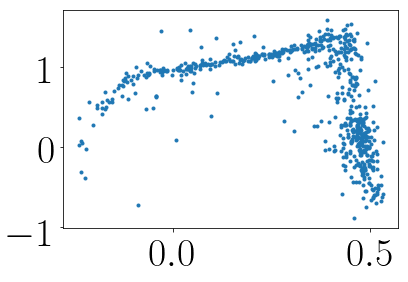

In [49]:
plt.plot(logbprp, logp, ".")

In [50]:
log_age = np.ones(len(logp))*np.log10(650*1e6)

Add the Sun.

In [51]:
sun_age, sun_prot, sun_color = np.array([np.log10(4.56*1e9)]), np.array([np.log10(26)]), np.array([np.log10(.82)])
sun_err, sun_eep = np.array([.0001]), np.array([355])

logbprp_sun = np.concatenate((logbprp, sun_color))
logp_sun = np.concatenate((logp, sun_prot))
log_age_sun = np.concatenate((log_age, sun_age))
logp_err_sun = np.concatenate((logp_err, sun_err))
eep_sun = np.concatenate((eep, sun_eep))

Fit a broken power law to the data.

In [52]:
def bpl_model(p, logbprp, logage, br=.43):
    logp = np.zeros(len(logbprp))
    cool = logbprp >= br
    hot = logbprp < -.25
    warm = (logbprp > -.25) * (logbprp <= br)
    logp[warm] = np.polyval(p[:5], logbprp[warm]) + p[5]*logage[warm]
    logp[cool] = np.polyval(p[6:], logbprp[cool]) + p[5]*logage[cool]
    logp[hot] = np.ones(len(logbprp[hot]))*0
    return logp

def bpr_nll(p, logbprp, logage, logp, logp_err):
    mod = bpl_model(p, logbprp, logage)
    var = logp_err**2
    return - np.sum(-.5 * (mod - logp)**2/var - .5*np.log(2*np.pi*var))

In [55]:
p0_bpl = np.ones(8)
bpl_result = sco.minimize(bpr_nll, p0_bpl, args=(logbprp_sun, log_age_sun, logp_sun, np.ones_like(logp_sun)*.1))
print("parameters = ", list(bpl_result.x))

parameters =  [-78.28974014954993, 33.03040623820474, -2.2672595564004903, 0.6812268828606771, -5.147626160298859, 0.6898497084797756, -13.558904758485177, 0.5591352677414279]


Plot the fit.

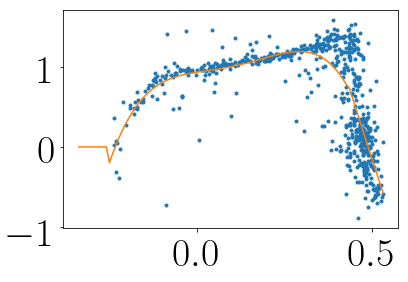

In [56]:
plt.plot(logbprp_sun, logp_sun, ".")
xplot = np.linspace(min(logbprp_sun) - .1, max(logbprp_sun), 100)
plt.plot(xplot, bpl_model(bpl_result.x, xplot, np.ones_like(xplot)*np.log10(650*1e6)))

This fit would be significantly improved with some sigma clipping!

/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


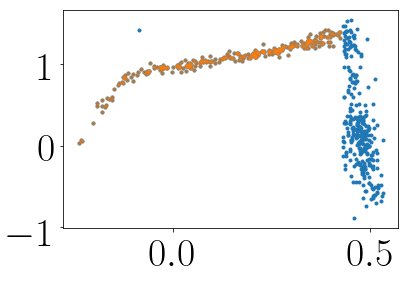

In [57]:
def sigma_clip(x, y, yerr, sig=4, iterations=10):
    finite_mask = np.isfinite(x) * np.isfinite(y)
    x, y, yerr = x[finite_mask], y[finite_mask], yerr[finite_mask]
    new_x, new_y, new_yerr = x*1, y*1, yerr*1
    
    for i in range(iterations):
        A = np.vander(new_x, 6)
        ATA = np.dot(A.T, A)
        pr = np.linalg.solve(ATA, np.dot(A.T, new_y))
        y_pred = np.polyval(pr, new_x)
        sigma = np.std(np.abs(new_y - y_pred))
        outlier_mask = np.abs(new_y - y_pred) < sig*sigma
        new_x, new_y, new_yerr = new_x[outlier_mask], new_y[outlier_mask], new_yerr[outlier_mask]
    
    return new_x, new_y, new_yerr

hot_mask = logbprp < .43
x_clipped, y_clipped, yerr_clipped = sigma_clip(logbprp[hot_mask], logp[hot_mask], logp_err[hot_mask],
                                               iterations=20)

ncool, nhot = len(logbprp[~hot_mask]), len(x_clipped)
p_age = np.log10(650*1e6)
logbprp_clipped = np.concatenate((logbprp[~hot_mask], x_clipped, sun_color))
logp_clipped = np.concatenate((logp[~hot_mask], y_clipped, sun_prot))
logp_err_clipped = np.concatenate((logp_err[~hot_mask], yerr_clipped, np.array([.00001])))
log_age_clipped = np.concatenate((np.ones(len(logbprp[~hot_mask]))*p_age, np.ones(len(x_clipped))*p_age, sun_age))

plt.plot(logbprp_clipped, logp_clipped, ".")
plt.plot(x_clipped, y_clipped, ".", alpha=.5)

In [58]:
bpl_result = sco.minimize(bpr_nll, p0_bpl, args=(logbprp_clipped, 
                                                 log_age_clipped, logp_clipped, 
                                                 np.ones_like(logp_clipped)*.1))
print("parameters = ", list(bpl_result.x))

parameters =  [-38.957586198640314, 28.709418579540294, -4.919056437046026, 0.7161114835620975, -4.716819674578521, 0.6470950862322454, -13.558898318835137, 0.9359250478865809]


Text(0, 0.5, '$\\sigma$')

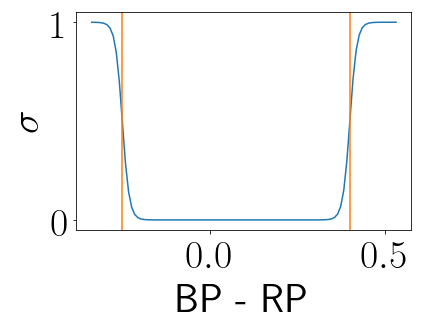

In [59]:
k = 100

def sigmoid(k, x0, L, x):
    return L/(np.exp(-k*(x - x0)) + 1)

sigma = sigmoid(k, .4, 1., xplot) + sigmoid(k, .25, 1., -xplot)

plt.plot(xplot, sigma)
plt.axvline(.4, color="C1")
plt.axvline(-.25, color="C1")

plt.xlabel("BP - RP")
plt.ylabel("$\sigma$")

# def sigmoid_variance(bprp, eep):
#     return sigmoid(k, .4, xplot) + sigmoid(k, .25, -xplot)

Text(0, 0.5, '$\\sigma$')

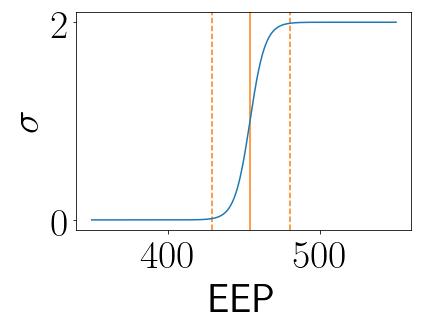

In [60]:
eep_plot = np.linspace(350, 550, 1000)
sigma_eep = sigmoid(.2, 454, 2., eep_plot)
plt.axvline(454, color="C1")
plt.axvline(429, color="C1", ls="--")
plt.axvline(480, color="C1", ls="--")
plt.plot(eep_plot, sigma_eep)
plt.xlabel("EEP")
plt.ylabel("$\sigma$")

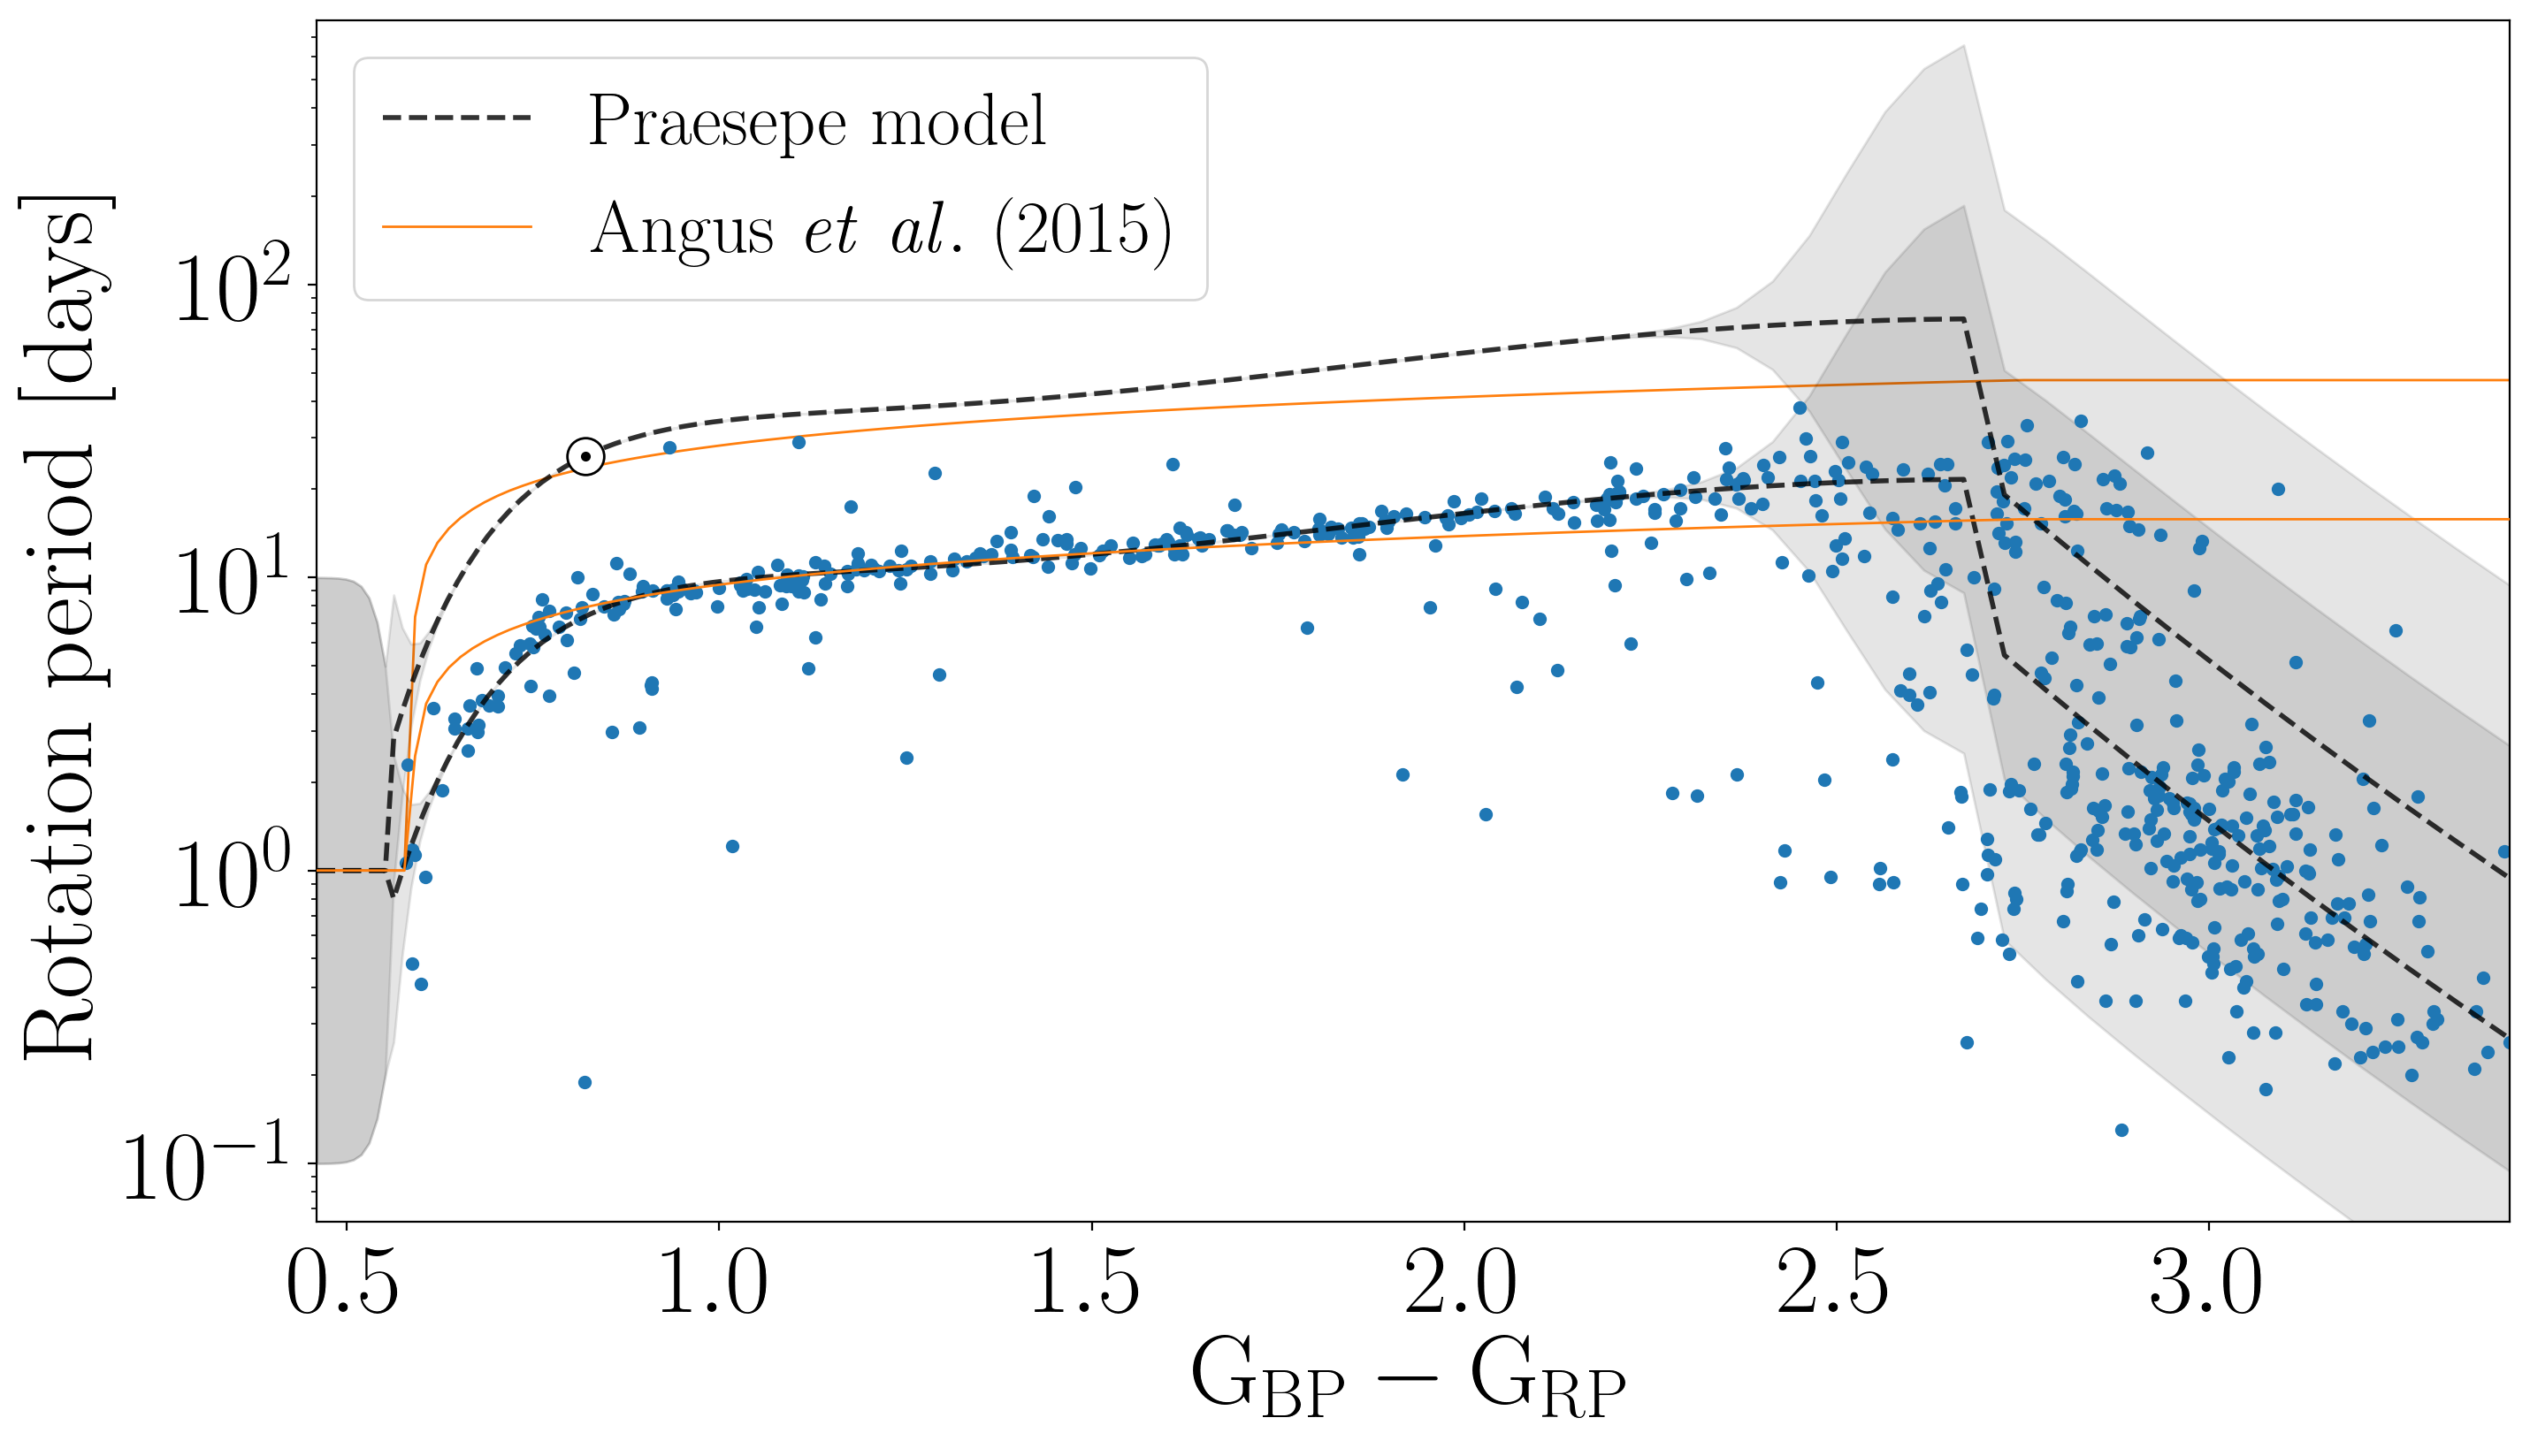

In [61]:
plt.figure(figsize=(16, 9), dpi=200)
plt.plot(10**logbprp_sun, 10**logp_sun, ".", ms=9, zorder=1)

mean = bpl_model(bpl_result.x, xplot, np.ones_like(xplot)*np.log10(4.56*1e9))
plt.plot(10**xplot, 10**mean, lw=2, zorder=2, color="k", ls="--", alpha=.8, rasterized=True)
plt.fill_between(10**xplot, 10**(mean - sigma), 10**(mean + sigma), color="k", alpha=.1, rasterized=True)

mean = bpl_model(bpl_result.x, xplot, np.ones_like(xplot)*np.log10(650*1e6))
plt.fill_between(10**xplot, 10**(mean - sigma), 10**(mean + sigma), color="k", alpha=.1, rasterized=True)
plt.plot(10**xplot, 10**mean, lw=2, color="k", ls="--", alpha=.8, rasterized=True,
        label="$\mathrm{Praesepe~model}$")

plt.plot(10**sun_color, 10**sun_prot, "wo", markeredgecolor="k", ms=15, zorder=2, rasterized=True)
plt.plot(10**sun_color, 10**sun_prot, ".k", zorder=2, rasterized=True)

plt.xlim(10**(min(xplot)), 10**(max(xplot)))
plt.ylim(10**-1.2, 10**2.9)

plt.xlabel("$\mathrm{G_{BP} - G_{RP}}$")
plt.ylabel("$\mathrm{Rotation~period~[days]}$")
plt.yscale("log")

# Add Angus (2015) model
def bv_2_bprp(bv):
    """
    Numbers from https://arxiv.org/pdf/1008.0815.pdf
    """
    a, b, c, d = .0981, 1.4290, -.0269, .0061  # sigma = .43
    return a + b*bv + c*bv**2 + d*bv**3


def bprp_2_bv(bprp):
    """
    Try to find the analytic version of this, please!
    """
    bv_iter = np.linspace(0., 2., 10000)
    bprp_pred = [bv_2_bprp(bv) for bv in bv_iter]
    diffs = bprp - np.array(bprp_pred)
    return bv_iter[np.argmin(diffs**2)]

import stardate.lhf as sdl

xs = np.linspace(-.25, .6, 100)
bv, log_periods_praesepe, log_periods_sun, log_sigs = [np.zeros_like(xs) for i in range(4)]
for i, _x in enumerate(xs):
    bv[i] = bprp_2_bv(10**_x)
    log_periods_praesepe[i] = sdl.gyro_model(np.log10(625*1e6), bv[i])
    log_periods_sun[i] = sdl.gyro_model(np.log10(4.56*1e9), bv[i])
    log_sigs[i] = sdl.sigma(bv[i], 355)
    
plt.plot(10**xs-.15, 10**log_periods_praesepe, color="C1", lw=1, zorder=3, ms=35, rasterized=True)
plt.plot(10**xs-.15, 10**log_periods_sun, color="C1", lw=1, zorder=0, rasterized=True,
         label="$\mathrm{Angus~{\it et~al.}~(2015)}$")

plt.legend(loc="upper left")
plt.savefig("../praesepe.pdf")